In [155]:
import numpy as np                                                                        
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
from astropy    import constants as const
from astropy.io import ascii
import pandas as pd

# from scipy.integrate import simps
from numpy import log10, exp

kpc = const.kpc.cgs.value

atom = ['Lya','HeII','CIV']

def read_file(path_way, atom):
    Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
    Mod.ionic_names

    N_H = sum(Mod.dr*Mod.nH)
    # solar_metallicitiy from von Steiger et al. 2016
    frac_He = 1.0E-01
    frac_C = 4.47E-04
    frac_O = 6.61E-04
    frac_N = 9.33E-05
    frac_Mg = 7.08E-05

    N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
    N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
    N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
    N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
    N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
    N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

    num = len(Mod.nH)
    r_CIV = path_way +  '.ele_C'
    f = open(r_CIV,'r')
    header = f.readline()
    CIV_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[4])
        CIV_frac[i] = j
        i = i + 1

    r_He = path_way +  '.ele_He'
    f = open(r_He,'r')
    header = f.readline()
    HeII_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[2])
        HeII_frac[i] = j
        i = i + 1



    n_H= Mod.nH
    n_He = n_H*frac_He
    n_C = n_H*frac_C
    nden_CIV = CIV_frac*n_C
    nden_HeII = HeII_frac*n_He

    # tt = nden_CIV / n_H
    # print(tt.mean())

    if atom == 'CIV':
        Cloudy_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
        Cloudy_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
        Cloudy_den = nden_CIV
    elif atom == 'Lya':
        Cloudy_Lum= float(Mod.get_emis_vol('H__1_121567A'))
        Cloudy_emis = Mod.get_emis('H__1_121567A')
        Cloudy_den = n_H
    elif atom == 'HeII':
        Cloudy_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
        Cloudy_emis = Mod.get_emis('HE_2_164043A')
        Cloudy_den = nden_HeII
    return Cloudy_Lum , Cloudy_emis ,Cloudy_den

def radius_dr(path, atom):
    Mod = pc.CloudyModel(path, cloudy_version_major=23)
    radius = Mod.radius/kpc
    radius_kpc =Mod.radius 
    dr = Mod.dr 
    return radius, radius_kpc, dr

def make_data_file(path,atom):
    lum ,emis ,den = read_file(path,atom)
    radius , radius_kpc, dr =  radius_dr(path,atom)
    tt =  pd.DataFrame(np.column_stack((radius,emis,den)))
    tt.to_csv('/home/jin/Data_CIV_code_python/CIV_cloudy.txt', sep='\t',index=False,header =False)
    tt.to_csv('/home/jin/RT_code/CIV_cloudy.txt', sep='\t',index = False,header=False)
    return print("make data file!")

def SB(R_project,radius_kpc, emissivity , dr):
    R_projection = np.copy(R_project)
    surface_brightness = np.zeros(len(R_project))
    Lumin = np.zeros(len(R_project))
    T_Lumin = np.zeros(len(R_project))
    
    for ii, bb in enumerate(R_projection[:-1]):
        array_R = np.where(radius_kpc >= bb)[0]
        r_surface_brightness = 0
        for dR in (array_R):
            r_surface_brightness += emissivity[dR] * dr[dR]
        surface_brightness[ii] = 2*r_surface_brightness
        dR_pro = R_projection[ii+1] - R_projection[ii] 
        Lumin[ii] = 4*np.pi*bb*surface_brightness[ii] * dR_pro

    return R_projection, surface_brightness, Lumin

def Total_Luminosity(radius_kpc, emissivity , dr):
    T_Lumin = np.zeros(len(radius_kpc))
    for ii, bb in enumerate(radius_kpc):
        T_Lumin[ii] = 4 * np.pi * bb**2 *emissivity[ii] * dr[ii]
    return T_Lumin


def RT_SB(path):
    name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
    data_sp = pd.read_csv(path, sep='\s+', header=None,names=name)
    rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()
    return rad/kpc, rad, SB_t 

def find_y(x_find,x,y):
    ii = int(np.where(x <= x_find)[0][-1])
    # print(ii)
    y_find = (y[ii+1] -y[ii]) / (x[ii+1] - x[ii])*(x_find - x[ii]) + y[ii]
    return y_find

In [156]:
#Window_path
path_or = r'/home/jin/Data_CIV_code_python/Origin/CIV_Lumin_42' # Ryd =1 or 4 # no OTS , LT 
path_n = r'/home/jin/Data_CIV_code_python/OTS_y_LT_n/CIV_Lumin_42' # OTS , no LT
path_y = r'/home/jin/Data_CIV_code_python/OTS_y_LT_y/CIV_Lumin_42' # OTS , yes LT
path_LT = r'/home/jin/Data_CIV_code_python/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

In [157]:
# #Ubuntu_path
# path_or = r'/home/jin/T_Cloudy/Origin/CIV_Lumin_42' # Ryd =1 or 4 # no OTS , LT 
# path_n = r'/home/jin/T_Cloudy/OTS_y_LT_n/CIV_Lumin_42' # OTS , no LT
# path_y = r'/home/jin/T_Cloudy/OTS_y_LT_y/CIV_Lumin_42' # OTS , yes LT
# path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

In [168]:
atom_N = 'CIV' 

radius_or , radius_kpc_or, dr_or = radius_dr(path_or,atom_N)
radius_n, radius_kpc_n, dr_n = radius_dr(path_n,atom_N)
radius_y, radius_kpc_y, dr_y = radius_dr(path_y,atom_N)
radius_LT, radius_kpc_LT, dr_LT = radius_dr(path_LT,atom_N)

lum_civ_or, emis_civ_or , den_civ_or = read_file(path_or,atom_N)
lum_civ_n, emis_civ_n , den_civ_n = read_file(path_n,atom_N)
lum_civ_y, emis_civ_y , den_civ_y = read_file(path_y,atom_N)
lum_civ_LT, emis_civ_LT , den_civ_LT = read_file(path_LT,atom_N)
#  atom = ['Lya','HeII','CIV']

#Make data_file
# make_data_file(path_LT,atom_N)


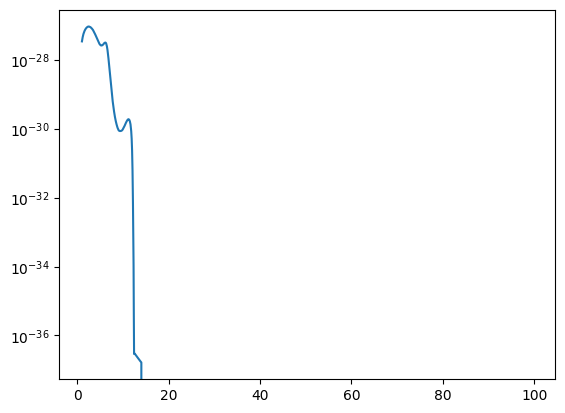

In [173]:
plt.plot(radius_LT , emis_civ_LT)
plt.yscale('log')

In [174]:
#Window_path_RT
RT_path_or =r'/home/jin/Data_CIV_code_python/Origin/data_RT_ryd_4/N_atom100E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
RT_path_n =r'/home/jin/Data_CIV_code_python/OTS_y_LT_n/data_RT/N_atom100E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
RT_path_y =r'/home/jin/Data_CIV_code_python/OTS_y_LT_y/data_RT/N_atom100E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
RT_path_LT =r'/home/jin/Data_CIV_code_python/OTS_n_LT_y/data_RT/N_atom100E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'

In [160]:
# #Ubuntu_path_RT

# RT_path_or =r'/home/jin/T_Cloudy/Origin/data_RT_ryd_4/N_atom100E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# RT_path_n =r'/home/jin/T_Cloudy/OTS_y_LT_n/data_RT/N_atom100E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# RT_path_y =r'/home/jin/T_Cloudy/OTS_y_LT_y/data_RT/N_atom100E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
# RT_path_LT =r'/home/jin/T_Cloudy/OTS_n_LT_y/data_RT/N_atom100E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'


In [175]:
rad_or, rad_or_kpc, SB_or_t = RT_SB(RT_path_or)
rad_n, rad_n_kpc, SB_n_t = RT_SB(RT_path_n)
rad_y, rad_y_kpc, SB_y_t = RT_SB(RT_path_y)
rad_LT, rad_LT_kpc, SB_LT_t = RT_SB(RT_path_LT)


R_project_or, SB_or , Lumin_or = SB(rad_or_kpc,radius_kpc_or,emis_civ_or,dr_or)
R_project_n,SB_n , Lumin_n = SB(rad_n_kpc, radius_kpc_n, emis_civ_n,dr_n)
R_project_y, SB_y , Lumin_y  = SB(rad_y_kpc,radius_kpc_y ,emis_civ_y,dr_y)
R_project_LT, SB_LT , Lumin_LT = SB(rad_LT_kpc,radius_kpc_LT, emis_civ_LT,dr_LT)

T_Lumin_or = Total_Luminosity(radius_kpc_or,emis_civ_or,dr_or)
T_Lumin_n = Total_Luminosity(radius_kpc_n,emis_civ_n,dr_n)
T_Lumin_y = Total_Luminosity(radius_kpc_y,emis_civ_y,dr_y)
T_Lumin_LT = Total_Luminosity(radius_kpc_LT,emis_civ_LT,dr_LT)

In [177]:
print(sum(T_Lumin_y), lum_civ_y , sum(Lumin_y))

1.1919512254754257e+40 1.1919512254754257e+40 1.1917772537074612e+40


0.0


(-0.5, 20.0)

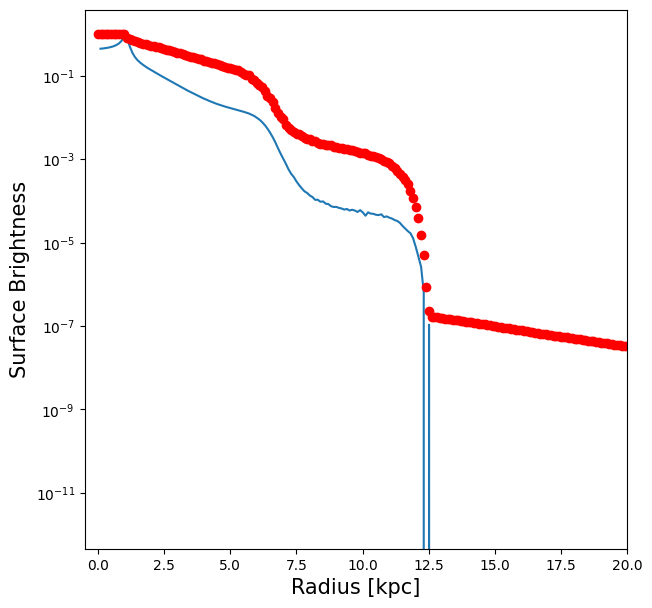

In [180]:
fig = plt.figure(1, figsize= (7,7))

normal = SB_n_t[1:].max()
plt.plot(rad_n[1:] , SB_n_t[1:] / normal)

normal = SB_n[1:].max()
plt.plot(R_project_n/kpc, SB_n / normal ,'ro')

print((R_project_n/kpc)[0])
plt.xlabel('Radius [kpc]',fontsize=15)
plt.ylabel('Surface Brightness',fontsize = 15)
plt.yscale('log')
plt.xlim(-0.5,20)
# plt.ylim(10**(-19),10**(-13))
# plt.legend()